In [3]:
library(Seurat)
library(tidyverse)
library(cowplot)

Attaching SeuratObject

── Attaching packages ──────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.1     ✔ purrr   1.0.0
✔ tibble  3.2.0     ✔ dplyr   1.1.0
✔ tidyr   1.2.1     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ─────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [3]:
obj_list = readRDS("/afs/crc.nd.edu/user/m/mzarodn2/Private/scrnaseq/data/Brain_atlas/obj_list.rds")

In [ ]:
integrate_seurat <- function(obj_list) {
  
  options(future.globals.maxSize = 4000 * 1024^2)
  
  obj_list <- lapply(X = obj_list, FUN = function(x) {
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
  })
  
  
  integ_features <- SelectIntegrationFeatures(object.list = obj_list) 
 
  obj_list <- lapply(X = obj_list, FUN = function(x) {
    x <- ScaleData(x, features = integ_features, verbose = FALSE)
    x <- RunPCA(x, features = integ_features, verbose = FALSE)
  })
  
  # Find best buddies - can take a while to run
  integ_anchors <- FindIntegrationAnchors(object.list = obj_list, 
                                          anchor.features = integ_features,
                                          reduction = "rpca")
  
  # Integrate across conditions
  obj <- IntegrateData(anchorset = integ_anchors, k.weight = 50)
  return(obj)
}

In [ ]:
sample_ids = lapply(obj_list, function(x) {unique(x$sample)})
obj_list = obj_list[!grepl("AD", unlist(sample_ids))]

In [ ]:
integrated_seurat <- integrate_seurat(obj_list)

In [ ]:
saveRDS(integrated_seurat, "/afs/crc.nd.edu/user/m/mzarodn2/Private/scrnaseq/data/Brain_atlas/integrated_seurat.rds")

In [ ]:
DefaultAssay(integrated_seurat) <- "integrated"

# Run the standard workflow for visualization and clustering
integrated_seurat <- ScaleData(integrated_seurat, verbose = FALSE)
integrated_seurat <- RunPCA(integrated_seurat, npcs = 30, verbose = FALSE)
ElbowPlot(integrated_seurat)

In [ ]:
integrated_seurat <- RunUMAP(integrated_seurat, reduction = "pca", dims = 1:11)
integrated_seurat <- FindNeighbors(integrated_seurat, reduction = "pca", dims = 1:11)
integrated_seurat <- FindClusters(integrated_seurat, resolution = 0.3)
Idents(integrated_seurat) <- "integrated_snn_res.0.3"

DimPlot(integrated_seurat, label = T)

In [ ]:
cell_type_markers = read_tsv("/afs/crc.nd.edu/user/m/mzarodn2/Private/scrnaseq/data/Brain_atlas/top5_cell_type_markers.tsv")
unique(cell_type_markers$`Cell Type`)

In [ ]:
DefaultAssay(integrated_seurat) <- "RNA"

In [ ]:
DotPlot(integrated_seurat,
       features = cell_type_markers[cell_type_markers$`Cell Type`=="BEC, Arterial",]$Gene)

In [ ]:
Idents(integrated_seurat) <- "integrated_snn_res.0.3"
integrated_seurat <- RenameIdents(object = integrated_seurat, 
                              "0" = "BEC, Arterial",
                              "1" = "Pericyte",
                              "2" = "Oligo",
                              "3" = "Astrocyte",
                              "4" = "BEC, Capillary/Venous",
                              "5" = "SMC",
                              "6" = "Astrocyte",
                              "7" = "Immune",
                              "8" = "Perivascular Fibroblast",
                              "9" = "OPC",
                              "10" = "Neuron",
                           "11" = "Ependymal",
                           "12" = "BEC, Arterial",
                           "13" = "BEC, Arterial",
                           "14" = "Pericyte",
                          "15" = "BEC, Arterial",
                          "16" = "Oligo",
                          "17" = "NA",
                          "18" = "Meningeal Fibroblast")
integrated_seurat$cell.type = Idents(integrated_seurat)

p = DimPlot(integrated_seurat, label = TRUE, group.by = "cell.type")
p

In [ ]:
integrated_seurat = subset(integrated_seurat, idents = "NA", invert = TRUE)

In [ ]:
p = DimPlot(integrated_seurat, label = TRUE, group.by = "cell.type")
p

In [ ]:
saveRDS(integrated_seurat, "/afs/crc.nd.edu/user/m/mzarodn2/Private/scrnaseq/data/Brain_atlas/integrated_seurat.rds")

### Gene markers

In [2]:
integrated_seurat = readRDS("/afs/crc.nd.edu/user/m/mzarodn2/Private/scrnaseq/data/Brain_atlas/integrated_seurat.rds")

In [5]:
pfib_markers = FindMarkers(object = integrated_seurat,
                           ident.1 = "Perivascular Fibroblast",
                          min.pct = 0.5,
                           only.pos = T,
                          logfc.threshold = 1)

In [9]:
mfib_markers = FindMarkers(object = integrated_seurat,
                           ident.1 = "Meningeal Fibroblast",
                          min.pct = 0.5,
                           only.pos = T,
                          logfc.threshold = 1)

In [10]:
pc_markers = FindMarkers(object = integrated_seurat,
                           ident.1 = "Pericyte",
                          min.pct = 0.5,
                           only.pos = T,
                          logfc.threshold = 1)

In [11]:
smc_markers = FindMarkers(object = integrated_seurat,
                           ident.1 = "SMC",
                          min.pct = 0.5,
                           only.pos = T,
                          logfc.threshold = 1)

In [19]:
marker_table = rbind(
    pfib_markers %>% mutate(cell.type = "Perivascular fibroblast"),
    mfib_markers %>% mutate(cell.type = "Meningeal fibroblast"),
    pc_markers %>% mutate(cell.type = "Pericyte"),
    smc_markers %>% mutate(cell.type = "SMC"))

In [20]:
write.table(marker_table, "/afs/crc.nd.edu/user/m/mzarodn2/Private/scrnaseq/data/Brain_atlas/marker_genes.tsv", sep = "\t")

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



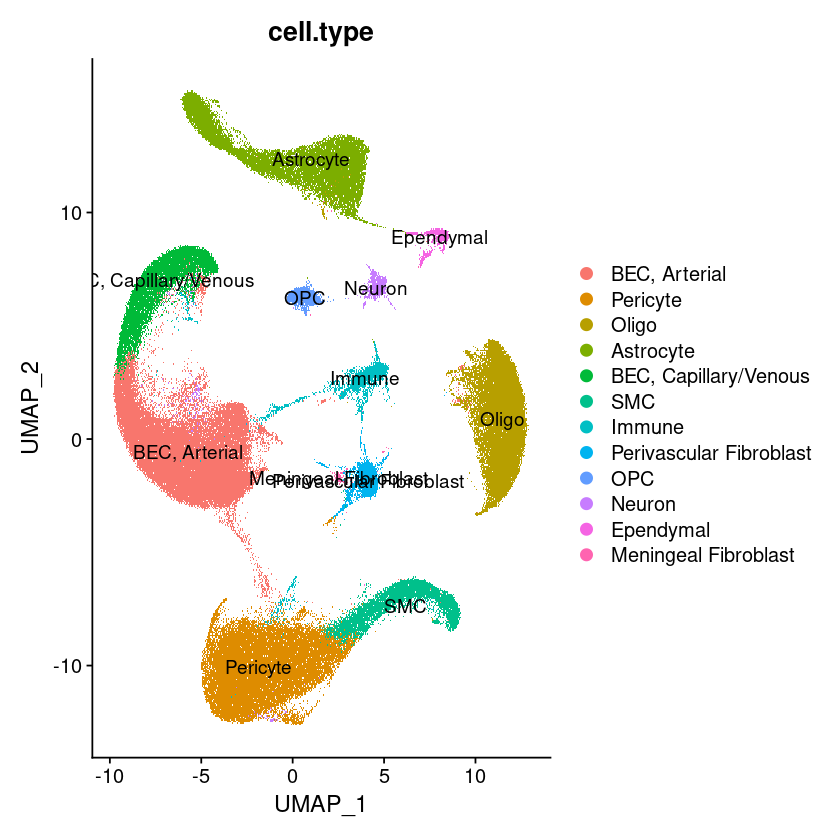

In [8]:
DimPlot(integrated_seurat, label = TRUE, group.by = "cell.type")

In [ ]:
integrated_seurat = subset(integrated_seurat, idents = c("Pericyte", "SMC", "Meningeal Fibroblast", "Perivascular Fibroblast"))

In [ ]:
p = DimPlot(integrated_seurat, label = TRUE, group.by = "cell.type")
p

In [ ]:
saveRDS(integrated_seurat, "/afs/crc.nd.edu/user/m/mzarodn2/Private/scrnaseq/data/Brain_atlas/integrated_seurat_stromal_subset.rds")

Integrating with data from tumors

In [2]:
integrated_seurat = readRDS("/afs/crc.nd.edu/user/m/mzarodn2/Private/scrnaseq/data/Brain_atlas/integrated_seurat_stromal_subset.rds")

In [1]:
DefaultAssay(integrated_seurat) = "RNA"

ERROR: Error in DefaultAssay(integrated_seurat) = "RNA": object 'integrated_seurat' not found


In [2]:
lgpt = readRDS("/afs/crc.nd.edu/user/m/mzarodn2/Private/scrnaseq/data/Brain_atlas/integration/SCPCP000002_stromal_cells.rds")
meningioma = readRDS("/afs/crc.nd.edu/user/m/mzarodn2/Private/scrnaseq/data/Brain_atlas/integration/Wang_Meningioma_stromal_cells.rds")
nf = readRDS("/afs/crc.nd.edu/user/m/mzarodn2/Private/scrnaseq/data/Brain_atlas/integration/GSE163028_RAW_stromal_cells.rds")
mets = readRDS("/afs/crc.nd.edu/user/m/mzarodn2/Private/scrnaseq/data/Brain_atlas/integration/GSE186344_stromal_cells.rds")
gbm = readRDS("/afs/crc.nd.edu/user/m/mzarodn2/Private/scrnaseq/data/Brain_atlas/integration/GSE182109_processed_muralcells.rds")

ERROR: Error in DefaultAssay(gbm) <- "RNA": could not find function "DefaultAssay<-"


In [4]:
DefaultAssay(gbm) <- "RNA"

In [5]:
meningioma$cell.type <- meningioma$Final_celltype
mets$cell.type <- mets$Cell_Type
gbm$cell.type <- gbm$cell.type.fine

overlapping_genes = Reduce(intersect, list(
  rownames(lgpt),
  rownames(meningioma),
  rownames(nf),
  rownames(mets),
  rownames(gbm)#,
#    rownames(integrated_seurat)
))

In [6]:
count_data = cbind(
  lgpt@assays$RNA@counts[overlapping_genes,],
  meningioma@assays$RNA@counts[overlapping_genes,],
  #nf@assays$RNA@counts[overlapping_genes,],
  mets@assays$RNA@counts[overlapping_genes,],
  gbm@assays$RNA@counts[overlapping_genes,]#,
    #integrated_seurat@assays$RNA@counts[overlapping_genes,]
  )

metadata = rbind(
  lgpt@meta.data %>% select(cell.type) %>% mutate(Dataset = "PLGG"),
  meningioma@meta.data %>% select(cell.type) %>% mutate(Dataset = "Meningioma"),
  #nf@meta.data %>% select(cell.type),
  mets@meta.data %>% select(cell.type) %>% mutate(Dataset = "BMets"),
  gbm@meta.data %>% select(cell.type) %>% mutate(Dataset = "GBM")#,
    #integrated_seurat@meta.data %>% select(cell.type) %>% mutate(Dataset = "Reference Atlas")
)

In [7]:
seurat_obj = CreateSeuratObject(
  counts = count_data,
  meta.data = metadata
)

nf = CreateSeuratObject(
  counts = nf@assays$RNA@counts[overlapping_genes,],
  meta.data = nf@meta.data %>% select(cell.type) %>% mutate(Dataset = "NF")
)

In [8]:
# NF is already normalized

seurat_obj <- NormalizeData(seurat_obj)
seurat_obj <- merge(seurat_obj, y = nf)
table(seurat_obj$Dataset)


     BMets        GBM Meningioma         NF       PLGG 
     16065       3729      12037      14445        163 

In [9]:
rm(lgpt, meningioma, nf, mets, gbm)

In [10]:
Idents(seurat_obj) <- seurat_obj$cell.type
unique(Idents(seurat_obj))

[1] Fibroblast           Mesenchymal subtypes Endothelial subtypes
 [4] PC-3                 MSC-like-c2          PC-1                
 [7] PC-2                 vSMCs                EC-3                
[10] EC-2                 EC-1                 MSC-like-c1         
[13] P-FB                 SMC                  PC                  
[16] M-FB                 EC                  
17 Levels: Fibroblast Mesenchymal subtypes Endothelial subtypes ... EC

In [11]:
seurat_obj = subset(seurat_obj, idents = c("Endothelial subtypes", "EC", "EC-1", "EC-2", "EC-3"), invert = TRUE)

In [12]:
library(SeuratWrappers)

seurat_obj <- FindVariableFeatures(seurat_obj)

seurat_obj <- RunFastMNN(object.list = SplitObject(seurat_obj, split.by = "Dataset"))
#saveRDS(seurat_obj_integrated, "/afs/crc.nd.edu/user/m/mzarodn2/Private/scrnaseq/data/Brain_atlas/integrated_tumor_woREF.rds")

Computing 2000 integration features

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from mnn.reconstructed_ to mnnreconstructed_”


In [13]:
seurat_obj <- RunUMAP(seurat_obj, reduction = "mnn", dims = 1:8)
seurat_obj <- FindNeighbors(seurat_obj, reduction = "mnn", dims = 1:8)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
17:34:11 UMAP embedding parameters a = 0.9922 b = 1.112

17:34:11 Read 32550 rows and found 8 numeric columns

17:34:11 Using Annoy for neighbor search, n_neighbors = 30

17:34:11 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:34:16 Writing NN index file to temp file /tmp/196011.1.debug/RtmpSpZbnY/file2d2de614e21cc6

17:34:16 Searching Annoy index using 1 thread, search_k = 3000

17:34:28 Annoy recall = 100%

17:34:30 Commencing smooth kNN distance calibration using 1 thread
 with tar

In [14]:
seurat_obj <- FindClusters(seurat_obj, resolution = 0.15)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 32550
Number of edges: 927620

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9321
Number of communities: 6
Elapsed time: 14 seconds


In [26]:
head(seurat_obj)

,orig.ident,nCount_RNA,nFeature_RNA,cell.type,Dataset,RNA_snn_res.0.25,seurat_clusters
,<chr>,<dbl>,<int>,<chr>,<chr>,<fct>,<fct>
SCPCS000043-CTGCATCTCATTCGGA,SeuratProject,37835.44,6708,Fibroblast,PLGG,5,5
SCPCS000043-GCTGGGTGTTAGAGTA,SeuratProject,35489.50,6197,Fibroblast,PLGG,5,5
SCPCS000043-AGGGTCCTCCATAGGT,SeuratProject,35657.72,5619,Fibroblast,PLGG,5,5
SCPCS000043-TCACATTCAGTGTACT,SeuratProject,35052.94,5655,Fibroblast,PLGG,5,5
SCPCS000043-ACCATTTTCACTGATG,SeuratProject,33431.90,6002,Fibroblast,PLGG,5,5
SCPCS000043-TTCTAACCAAACAGGC,SeuratProject,32614.71,5350,Fibroblast,PLGG,5,5
SCPCS000043-TAGACCACAGTTAAAG,SeuratProject,34841.69,5832,Fibroblast,PLGG,5,5
SCPCS000043-TGAGGGAGTTGCATTG,SeuratProject,35357.99,5735,Fibroblast,PLGG,5,5
SCPCS000043-GCCCAGACACTGAATC,SeuratProject,34084.97,5928,Fibroblast,PLGG,5,5


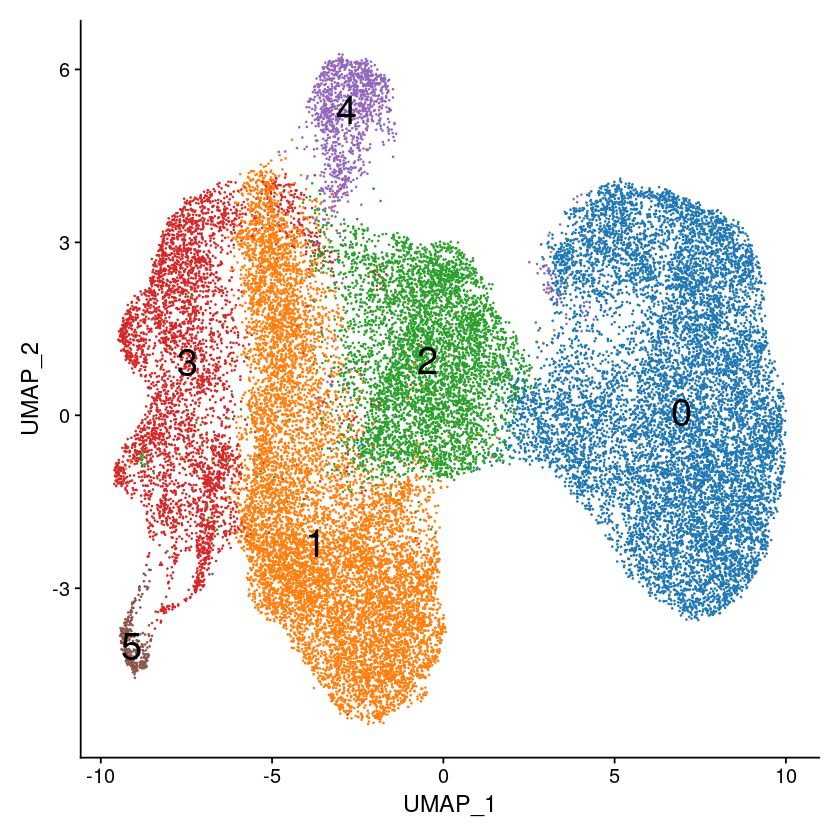

In [15]:
p = DimPlot(seurat_obj, label = T,  label.size = 8, pt.size = .1, cols = c('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf')) + NoLegend()
p

In [88]:
save_path = "/afs/crc.nd.edu/user/m/mzarodn2/Private/scrnaseq/data/Brain_atlas"
ggsave(p, path=save_path, filename= "integration_UMAP.pdf", width=5.1, height=5, dpi=700)

In [16]:
seurat_obj$cell.type.dataset = paste0(seurat_obj$cell.type, " (", seurat_obj$Dataset, ")")

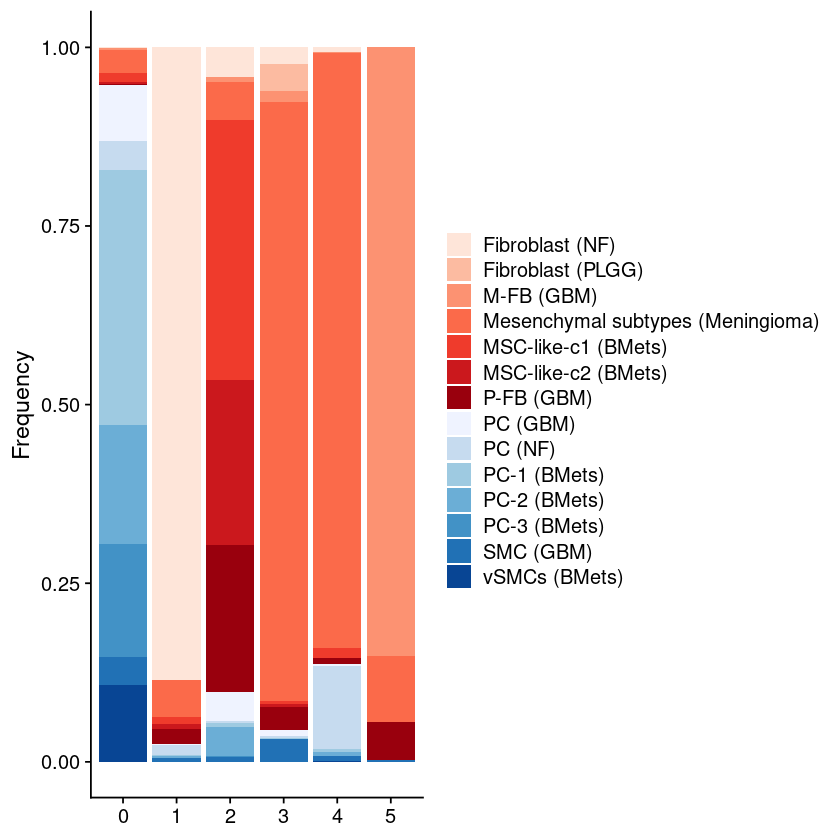

In [19]:
p = ggplot(seurat_obj@meta.data,
       aes(fill=cell.type.dataset, x=RNA_snn_res.0.15)) +
        scale_fill_manual(values = c(RColorBrewer::brewer.pal(7, "Reds"), RColorBrewer::brewer.pal(7, "Blues"))) +
    geom_bar(position="fill") +
  theme_cowplot() +
    labs(x = NULL, y = "Frequency", fill = NULL)
p

In [22]:
save_path = "/afs/crc.nd.edu/user/m/mzarodn2/Private/scrnaseq/data/Brain_atlas"
ggsave(p, path=save_path, filename= "integration_freq_per_cluster.pdf", width=6.1, height=3.5, dpi=700)

ERROR: Error in parse(text = x, srcfile = src): <text>:1:35: unexpected ','
1: RColorBrewer::brewer.pal(5, "Red"),
                                      ^


In [ ]:
DefaultAssay(seurat_obj) <- "RNA"
FeaturePlot(seurat_obj, "ACTA2")

In [21]:
saveRDS(seurat_obj, "/afs/crc.nd.edu/user/m/mzarodn2/Private/scrnaseq/data/Brain_atlas/integrated_tumor_REF.rds")